<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanill Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

import os
import random
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms as tfs

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      cropsize=110,
                      rescale=64
    ):

    # если ещё не скачаны - качаем архив
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("gdown http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("gdown http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    # читаем атрибуты
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    # пробегаемся по всем именам файлов, собираем словарь
    # c id, номером фото и путём до файла
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    # Мерджим всё
    # (у фото теперь такой же порядок как и у атрибутов)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # стэк трансформов
    transform = tfs.Compose([
                              tfs.CenterCrop(cropsize),
                              tfs.Resize(rescale, interpolation=tfs.InterpolationMode.BOX),
                              tfs.ToTensor(),
                            ])

    # сама функция препроцесса
    def preprocess(img):
        img = Image.open(img)
        img.load()
        return transform(img)

    all_photos =df['photo_path'].apply(preprocess)

    all_photos = torch.Tensor(np.stack(all_photos.values))#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_photos, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=50, shuffle=False)

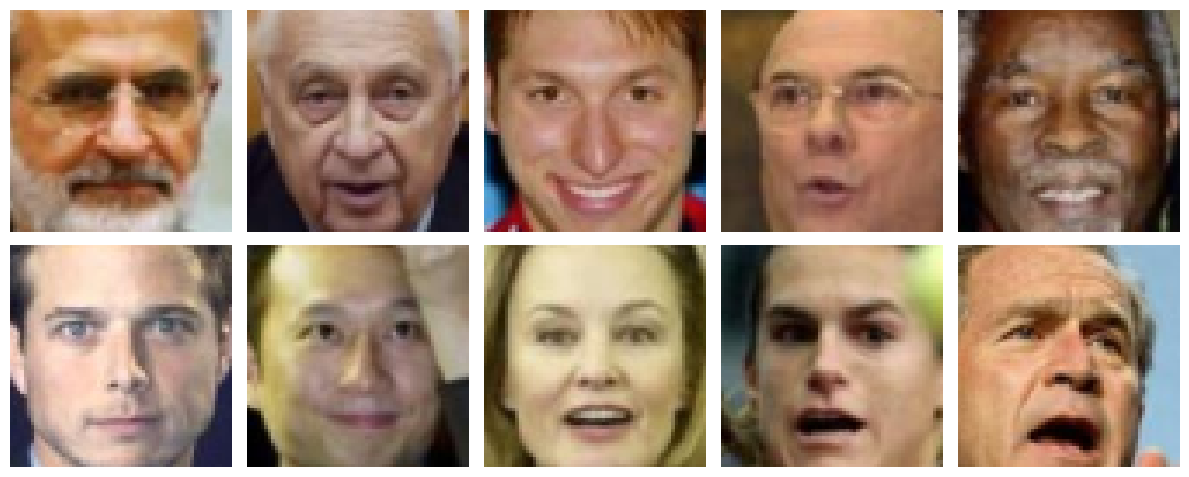

In [ ]:
# Визуализируем 10 случайных изображений из датасета
fig,ax = plt.subplots(2,5,figsize=(12,5))
axr = ax.ravel()
idxs = np.random.randint(0,len(data),10)
for i,ax in enumerate(axr):
    ax.imshow(data[idxs[i]].permute((1,2,0)))
    ax.axis('off')
plt.tight_layout()

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.Conv2d(64,128,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.Flatten(),
            nn.Linear(128*16*16,self.latent_dim)

        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128*16*16),
            nn.PReLU(),
            nn.Unflatten(1,(128,16,16)),
            nn.ConvTranspose2d(128,64,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.ConvTranspose2d(64,64, kernel_size=2, stride=2),
            nn.PReLU(),
            nn.Conv2d(64,3,kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder(512)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4, amsgrad=True)


## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
# Функция обучения и валидации.
def train(model, opt, loss_fn, epochs, data_tr, data_val, viz=True, scheduler=None) -> pd.DataFrame:
    """ Функция обучения и валидации.

    Args:
        model - модель
        opt - оптимизатор
        loss_fn - функция потерь
        epochs - количество эпох
        data_tr - трэйн-сет
        data_val - валидационный сет
        viz - визуализация промежуточных результатов
        scheduler - scheduler, если используется. По-умолчанию None.

    Returns:
        history: {
               epoch: номер эпохи
               train_loss: значение функции потерь на трэйн-сете
               val_loss: значения функции потерь на валидационном сете
               train_score: значение метрики на трэйн-сете
               val_score: значение метрики на валидационном сете
              }
    """
    model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}

    best_weights = model.state_dict()
    best_loss = 1e-8


    if viz:
        # Берём батч для визуализации. На каждой эпохе будем визуализировать результат именно на нём.
        X_viz = next(iter(data_val))

        # Создаем фигуру и axes для визуализации.
        fig = plt.figure(figsize=(25,5), facecolor='w')
        gs0 = fig.add_gridspec(1, 2)
        gs00 = gs0[0].subgridspec(2, 5)
        gs01 = gs0[1].subgridspec(2, 5)
        for a in range(2):
            for b in range(5):
                fig.add_subplot(gs00[a, b])
        fig.add_subplot(gs01[:,:-2] );

        # tqdm нам в этом случае не нужен, поэтому просто range создаем.
        pbar = range(epochs)
    else:
        # Если визуализации нет, будем выводить лосс и скор через tqdm
        pbar = trange(epochs, desc='Epoch:')
    tic = time.time()
    for epoch in pbar:

        # Обнуляем лоссы и метрики.
        avg_train_loss = 0
        avg_val_loss = 0

        # Train loop
        model.train()  # Переводим модель в train mode
        for X_batch in data_tr:
            # Скидываем батч на девайс
            X_batch = X_batch.to(device)
            # Обнуляем градиенты
            opt.zero_grad()
            # forward
            Y_pred,_ = model(X_batch)
            loss =  loss_fn(Y_pred, X_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # обновляем веса


            # Считаем лосс
            avg_train_loss += loss / len(data_tr)

        # Val loop
        model.eval()  # Переводим модель в eval mode
        with torch.no_grad():
            for X_val_batch in data_val:
                # Скидываем батч на девайс
                X_val_batch = X_val_batch.to(device)
                # forward
                Y_val_pred,_ = model(X_val_batch)
                val_loss =  loss_fn(Y_val_pred, X_val_batch) # forward-pass
                # Опять же считаем лосс
                avg_val_loss += val_loss / len(data_val)

        # сохраняем минимальный лосс и веса модели
        if avg_val_loss.cpu().item() < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()

        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss.cpu().item())
        history['val_loss'].append(avg_val_loss.cpu().item())

        # Убираем всё что можно с gpu, чистим кэш.
        Y_pred.cpu()
        Y_val_pred.cpu()
        avg_val_loss.cpu()
        avg_train_loss.cpu()
        X_batch.cpu(),
        X_val_batch.cpu()
        loss.cpu()
        val_loss.cpu()
        torch.cuda.empty_cache()

        # Визуализация промежуточных результатов
        model.eval()  # Переводим модель в eval mode
        if not viz:
            pbar.set_description(f'train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
        else:
            Y_hat = model(X_viz.to(device))[0].detach().cpu()# Скидываем предикт на cpu
            display.clear_output(wait=True)
            tempdf = pd.DataFrame(history)
            for k in range(5):
                fig.axes[k].imshow(X_viz[k].permute((1,2,0)))
                fig.axes[k].set_title('Source')
                fig.axes[k].set_axis_off()
                fig.axes[k+5].imshow(Y_hat[k].permute((1,2,0)))
                fig.axes[k+5].set_title('Reconstructed')
                fig.axes[k+5].set_axis_off()
            fig.axes[-1].plot(history['epoch'], tempdf['train_loss'], label='Train loss', color='lightblue')
            fig.axes[-1].plot(history['epoch'], tempdf['val_loss'], label='Val loss', color='orange')
            fig.axes[-1].grid(True, linestyle='--')
            fig.axes[-1].set_xlabel('Epoch')
            fig.axes[-1].set_title('Loss')
            fig.axes[-1].legend(['Train loss','Val loss'])
            fig.suptitle(f'Epoch: {(epoch+1):d}/{epochs:d} Elapsed time: {(time.time()-tic):.2f} sec\
                train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
            display.display(plt.gcf())
    if viz:
        # Стираем display, чтобы изображение обновлялось.
        display.clear_output(wait=True)

    # Сбрасываем модель на cpu. Чистим кэш.
    model.cpu()
    model.load_state_dict(best_weights)
    torch.cuda.empty_cache()
    return pd.DataFrame(history)

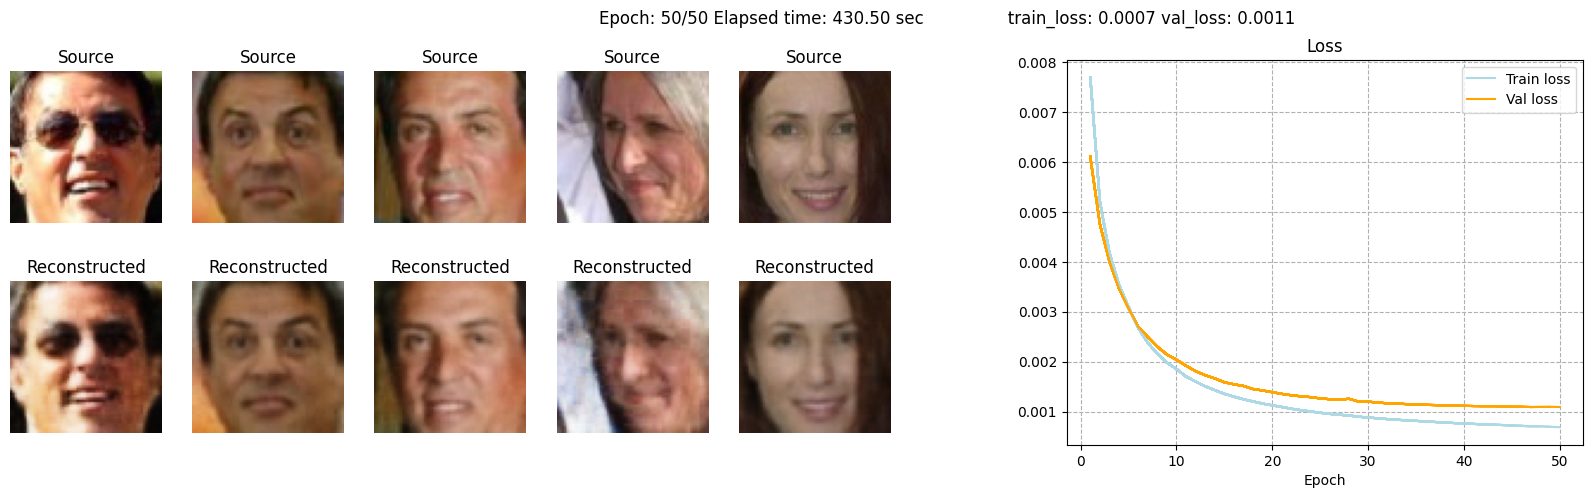

In [ ]:
history = train(model=autoencoder, opt=optimizer, loss_fn=criterion, epochs=50, data_tr=train_loader, data_val=val_loader, viz=True, scheduler=None)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
# Функция для визуализации исходных и реконструированных изображений
def visualize(model, data, num_imgs):
    idxs = np.random.randint(0,len(val_photos),num_imgs)
    encoded,_ = model(data[idxs])
    fig,ax = plt.subplots(2,num_imgs, figsize=(num_imgs*2+2,5))
    for i in range(len(idxs)):
        ax[0,i].imshow(data[idxs][i].permute((1,2,0)))
        ax[0,i].set_title('Source')
        ax[0,i].axis('off')
        ax[1,i].imshow(encoded[i].detach().permute((1,2,0)))
        ax[1,i].set_title('Reconstructed')
        ax[1,i].axis('off')
    plt.tight_layout()

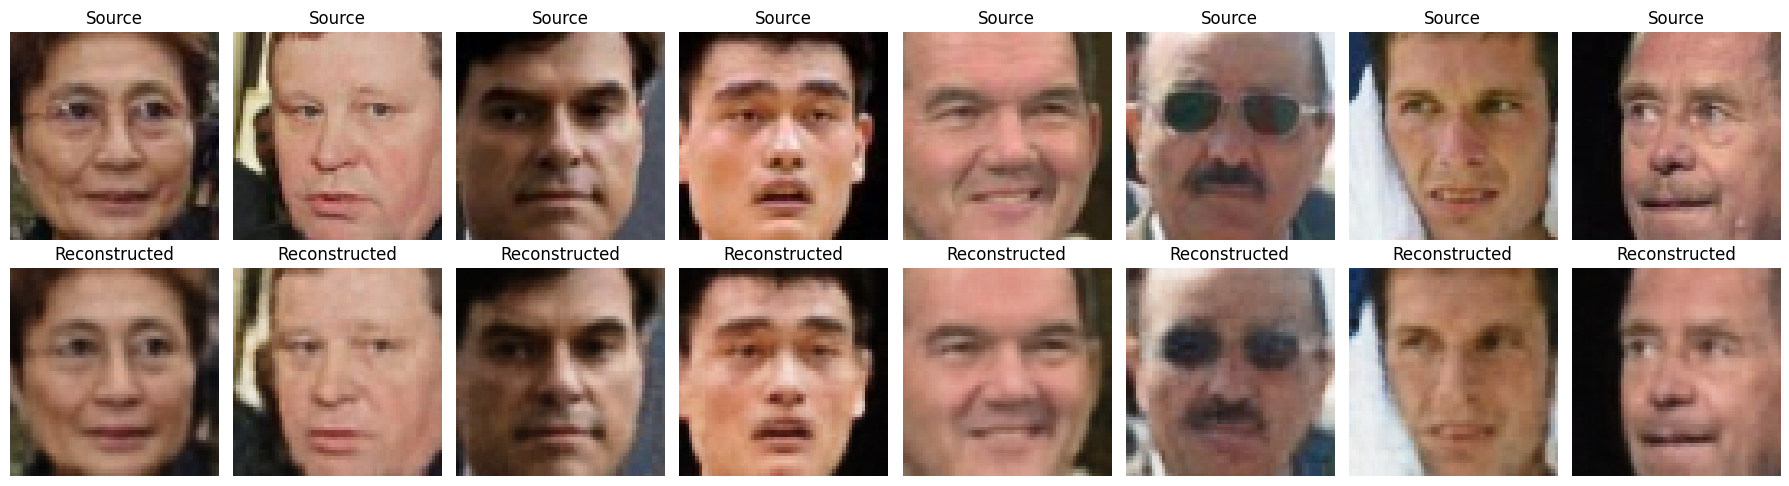

In [ ]:
visualize(autoencoder, val_photos, 8)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# Получим латентные векторы изобржений всего датасета, и трэйн и валидационных фото:
all_vecs = torch.FloatTensor()
with torch.no_grad():
    autoencoder.to(device)
    autoencoder.eval()
    for batch in train_loader:
        batch = batch.to(device)
        lat = autoencoder.encoder(batch)
        all_vecs = torch.cat((all_vecs,lat.cpu()))
        batch.cpu()
        del batch
        torch.cuda.empty_cache()
    autoencoder.cpu()

latent_mean = all_vecs.mean(axis=0)
latent_std = all_vecs.std(axis=0)

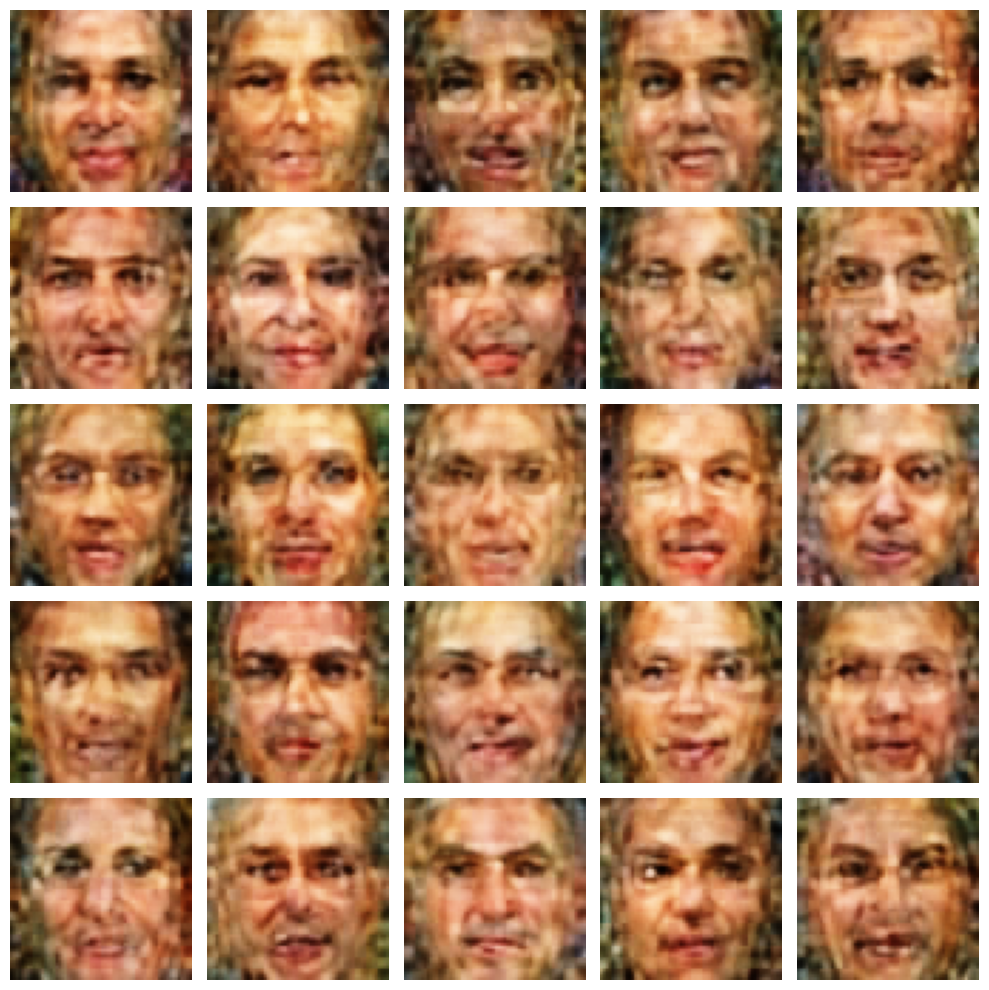

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(25, 512))
z = z*latent_std + latent_mean*2
output = autoencoder.decoder(torch.FloatTensor(z))
fig,ax = plt.subplots(5,5,figsize=(10,10))
axr = ax.ravel()
for i in range(len(z)):
    axr[i].imshow(output[i].detach().permute((1,2,0)))
    axr[i].axis('off')
plt.tight_layout()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# Функция для получения векторов
def get_vecs(model, data):
    model.to(device)
    model.eval()
    vecs = torch.FloatTensor()
    with torch.no_grad():
        for batch in data:
            batch = batch.to(device)
            lat = model.encoder(batch)
            vecs = torch.cat((vecs,lat.cpu()))
            batch.cpu()
            del batch
        model.cpu()
        torch.cuda.empty_cache()
    return vecs

In [ ]:
# Получаем индексы улыбающихся и грустных лиц, по 1000 каждого типа
smiling_idxs = train_attrs['Smiling'].sort_values(ascending=False)[:1000].index.values
grumpy_idxs = train_attrs['Smiling'].sort_values(ascending=True)[:1000].index.values

# Создаём для них даталоадеры.
smiling_loader =  torch.utils.data.DataLoader(train_photos[smiling_idxs], batch_size=50, shuffle=False)
grumpy_loader =  torch.utils.data.DataLoader(train_photos[grumpy_idxs], batch_size=50, shuffle=False)

# Усредняем векторы улыбающихся и грустных.
smiling_mean = (get_vecs(autoencoder,smiling_loader)).mean(axis=0)
grumpy_mean = (get_vecs(autoencoder,grumpy_loader)).mean(axis=0)

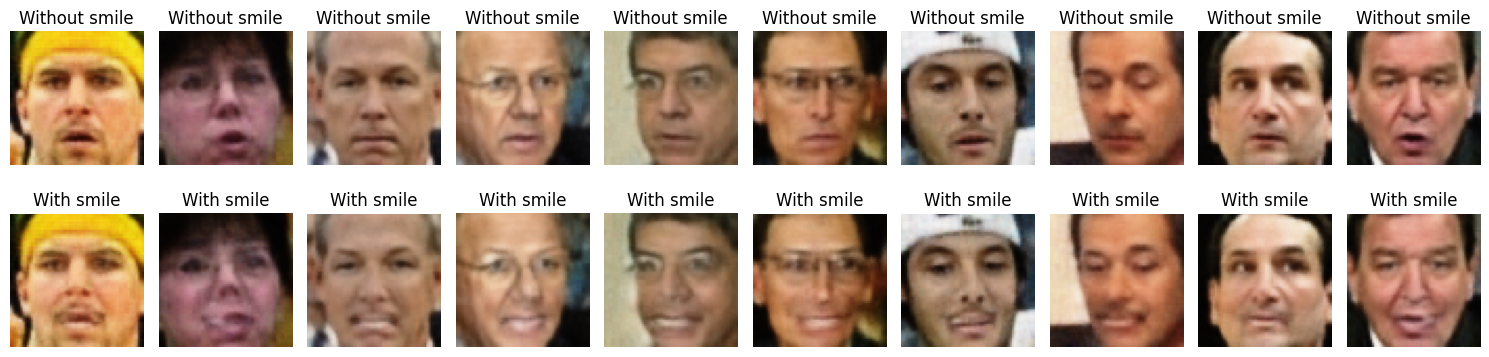

In [ ]:
# Получаем вектор улыбки вычитая усреднённый вектор грустных лиц из усреднённого вектора улыбающихся лиц.
smile_vector = smiling_mean-grumpy_mean

# Получаем батч векторов для нейтральных лиц
grumpy_test = autoencoder.encoder(next(iter(grumpy_loader)))[36:46]
# Добавляем улыбку
new_smile = grumpy_test+smile_vector
# Реконструируем изображения
with torch.no_grad():
    source = autoencoder.decoder(grumpy_test)
    adjusted = autoencoder.decoder(new_smile)
# Визуализация
fig,ax = plt.subplots(2,10,figsize=(15,4))
axr = ax.ravel()
for i in range(10):
    axr[i].imshow(source[i].permute((1,2,0)))
    axr[i].axis('off')
    axr[i].set_title('Without smile')
    axr[i+10].imshow(adjusted[i].permute((1,2,0)))
    axr[i+10].axis('off')
    axr[i+10].set_title('With smile')
plt.tight_layout();

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 256
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

dataloaders_mnist = {}
dataloaders_mnist['train'], dataloaders_mnist['val'] = train_loader, test_loader

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 38810284.43it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1042090.22it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:50<00:00, 32410.63it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5399809.74it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
features = 16

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        """<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>"""
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=784)
        )

    def encode(self, x):
        """<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>"""
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] #
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        #if self.training:
        """<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>"""
        std = torch.exp(0.5 * logsigma) # standard deviation

        eps = torch.randn_like(std) # `randn_like` as we need the same size
        #print('eps', eps.shape)
        sample = mu + (eps * std)

        return sample
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.

    def decode(self, z):
        """<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>"""
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        """<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>"""
        x = self.flatten(x).float()
        mu, logsigma = self.encode(x)

        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        return z

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    #<напишите код для KL-дивергенции, пользуясь формулой выше>
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    #<binary cross-entropy>
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    #<соедините тут две компоненты лосса. Mind the sign!>
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
def train_VAE(model, optimizer, loss_fn, n_epochs, dataloaders):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for batch, _ in dataloaders['train']:
            #print(batch.shape)
            optimizer.zero_grad()
            reconstruction, mu, logsigma = model(batch.to(device))
            #print(reconstruction.shape)
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = loss_fn(batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for batch, _ in dataloaders['val']:
                reconstruction, mu, logsigma = model(batch.to(device))
                reconstruction = reconstruction.view(-1, 1, 28, 28)
                loss = loss_fn(batch.to(device).float(), mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return model, train_losses, val_losses

In [ ]:
def small_prep_VAE(model):
    loss_fn = loss_vae
    lr = 0.001
    torch.manual_seed(42)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-04)

    return model, optimizer, loss_fn

In [ ]:
var_autoencoder = VAE().to(device)

trained_vae, train_loss_vae, val_loss_vae = train_VAE(*small_prep_VAE(var_autoencoder), 50, dataloaders_mnist)

  0%|          | 0/50 [00:00<?, ?it/s]

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
def VAE_eval_plot(model, test):
    model.eval()
    with torch.no_grad():
          for batch, _ in test:
            print(batch.shape)
            reconstruction, mu, logsigma = model(batch.to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            print(reconstruction.shape)
            reconstruction = np.rollaxis(reconstruction.detach().cpu().numpy(), 1, 4)
            print(reconstruction.shape)
            ground_truth = np.rollaxis(batch.numpy(), 1, 4)
            print(ground_truth.shape)
            break

    plt.figure(figsize=(10, 5))
    for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstruction[:5])):
        plt.subplot(2, 5, i+1)
        plt.imshow(np.squeeze(gt))
        plt.grid(None)
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(np.squeeze(res))
        plt.grid(None)
        plt.axis('off')

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
(256, 28, 28, 1)
(256, 28, 28, 1)


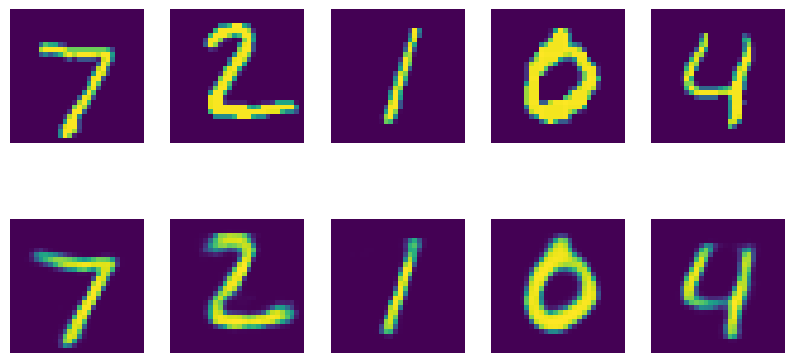

In [ ]:
VAE_eval_plot(trained_vae, dataloaders_mnist['val'])

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 16) for i in range(10)]) # генерируем случайные векторы
z = torch.FloatTensor(z) # перводим в тензор

In [ ]:
# получаем по каждой фотке mean, std
mean_vecs = []
std_vecs = []
with torch.no_grad():
    for img, _ in dataloaders_mnist['val']:
        #print(img.shape)
        mean, log_var = trained_vae.encode(img.to(device))
        mean_vecs.append(mean)
        std_vecs.append(log_var)


# склеиваем и считаем mean, std
total_mean_vecs = torch.cat(mean_vecs, dim=0)
mean = torch.mean(total_mean_vecs, dim=0)
total_std_vecs = torch.exp(0.5 * torch.cat(mean_vecs, dim=0))
std = torch.std(total_std_vecs, dim=0)

# получаем итоговый z
z = torch.FloatTensor(z).to(device) * std + mean


output = trained_vae.decode(z) # output = <скормите z декодеру>

# преобразуем наш флатэн в формат изображения для вывода
resulted = nn.Unflatten(dim=1, unflattened_size=(28,28,1))
output_new = resulted(output)

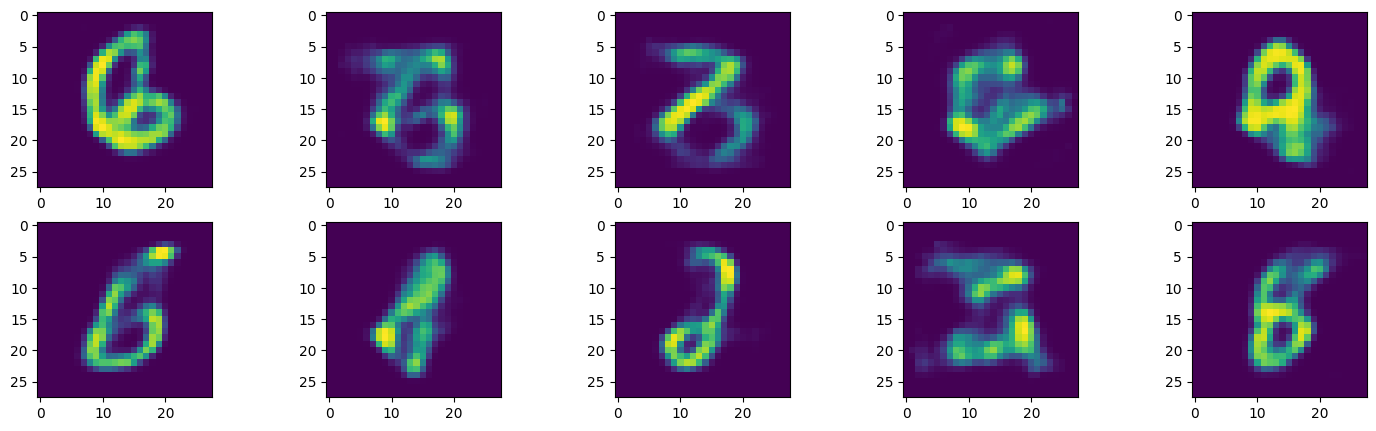

In [ ]:
# <выведите тут полученные картинки>
plt.figure(figsize=(18, 5))
for i in range(output_new.shape[0]):
    plt.subplot(2,output.shape[0] // 2, i + 1)
    generated = output_new[i].cpu().detach().numpy()
    plt.imshow(np.squeeze(generated))

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

encoded_samples = []
for img, label in test_dataset:
    # Encode image
    trained_vae.eval()
    with torch.no_grad():
        encoded_img  = trained_vae.get_latent_vector(img.to(device))

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}

    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

Что вы думаете о виде латентного представления?

Выводы:

1. В целом распределение компактное. Как в лекциях в обяснении про KL-дивергенцию. Всё вместе собрано нормальную компактную область [-80,80] по х и по y.
2. Отдельные классы(цифры) так же собраны с компактные кластеры. Кластеры между собой разделимы.
3. Более плотно лежат кластеры 4,7,9 и 5,3,8 и это логично. Цифры похожи, разделить их сложнее.


__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        """<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>"""
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=794, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features + 10, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=784)
        )

    def encode(self, x, class_num):
        """<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>"""
        x = self.flatten(x).float()
        #print(f"flattened{x.shape}")
        x_concatened = torch.cat([x, class_num], 1)
        #print("Concateneted", x_concatened.shape)
        x = self.encoder(x_concatened).view(-1, 2, features)
        #print('After_encoder',x.shape)
        mu = x[:, 0, :] # the first feature values as mean
        #print('mu', mu.shape)

        logsigma = x[:, 1, :] #
        #print('sigma', logsigma.shape)
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        #if self.training:
        """<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>"""
        std = torch.exp(0.5 * logsigma) # standard deviation
        #print('std', std.shape)
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        #print('eps', eps.shape)
        sample = mu + (eps * std)
        #print('sample', sample.shape)
        return sample
        #else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            #return mu

    def decode(self, z, class_num):
        """<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>"""
        z_concated = torch.cat([z, class_num], 1)
        x = self.decoder(z_concated)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x, class_num):
        """<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>"""
        x = self.flatten(x).float()
        #print(x.shape)
        mu, logsigma, class_num = self.encode(x, class_num)
        #print(mu.shape, logsigma.shape)


        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return reconstruction, mu, logsigma,

    def get_latent_vector(self, x, class_num):
        x = self.flatten(x).float()
        x_concatened = torch.cat([x, class_num], 1)
        x = self.encoder(x_concatened).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        return z

In [ ]:
cond_autoencoder = CVAE().to(device)

In [ ]:
cond_dim = train_loader.dataset.train_labels.unique().size(0)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning:

train_labels has been renamed targets



In [ ]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [ ]:
criterion = loss_vae

optimizer = torch.optim.AdamW(cond_autoencoder.parameters(), lr=0.001, weight_decay=1e-04)

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    cond_autoencoder.train()
    train_losses_per_epoch = []
    for batch, cond in train_loader:
        #print(batch.shape)
        cond = one_hot(cond, cond_dim)
        optimizer.zero_grad()
        reconstruction, mu, logsigma = cond_autoencoder(batch.to(device), cond.to(device))
        #print(reconstruction.shape)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    cond_autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, cond in test_loader:
            cond = one_hot(cond, cond_dim)
            reconstruction, mu, logsigma = cond_autoencoder(batch.to(device), cond.to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
z = np.array([np.random.normal(0, 1, 16) for i in range(1)]) # генерируем случайный вектор
z = torch.FloatTensor(z) # перводим в тензор

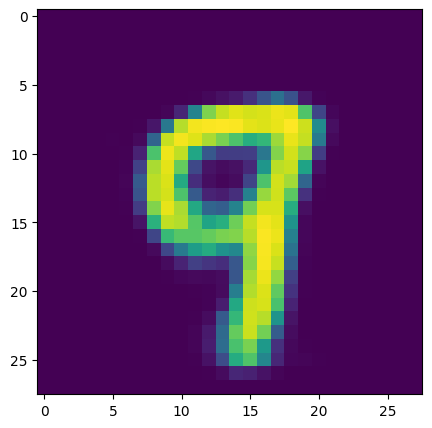

In [ ]:
mean_vecs = []
std_vecs = []
with torch.no_grad():
    for img, cond in test_loader:
        #print(img.shape)
        #print(cond.shape)
        cond = one_hot(cond, cond_dim)
        #print(cond.shape)
        mean, log_var, label = cond_autoencoder.encode(img.to(device), cond.to(device))
        mean_vecs.append(mean)
        std_vecs.append(log_var)


# склеиваем и считаем mean, std
total_mean_vecs = torch.cat(mean_vecs, dim=0)
mean = torch.mean(total_mean_vecs, dim=0)
total_std_vecs = torch.exp(0.5 * torch.cat(mean_vecs, dim=0))
std = torch.std(total_std_vecs, dim=0)

# получаем итоговый z
z = z.to(device) * std + mean

# закидываем циферку и полученный вектор в decoder и получаем четкий результат
output = cond_autoencoder.decode(z, one_hot(torch.LongTensor([9]), cond_dim).to(device)) # output = <скормите z декодеру>
resulted = nn.Unflatten(dim=1, unflattened_size=(28,28,1))
output_new = resulted(output)

plt.figure(figsize=(18, 5))

generated = output_new.cpu().detach().numpy()
plt.imshow(np.squeeze(generated))

plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
encoded_samples = []
for img, label in test_dataset:
    # Encode image

    cond_autoencoder.eval()
    with torch.no_grad():
        encoded_img  = cond_autoencoder.get_latent_vector(img.to(device),
                                                     one_hot(torch.LongTensor([label]), cond_dim).to(device))

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}

    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?


Видно что латентные векторы распределены нормально. Центры у классов расположены очень близко.<br> Но теперь уже не классы кластеризуются, а похоже что именно стили. Поэтому и сэмплировать гораздо проще из такого распределения.<br>Плюс можно ещё и сэмплировать так, что получим стили, которых не было в обучающей выборке. Таким образом можно новую стилистику генерить.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
# Функция, добавляющая шум к батчу изображений и нормализующая их к диапазону [0,1]
def addGaussianNoise(tensor, alpha):
    noise = torch.randn(tensor.shape)
    unnorm = (tensor*(1-alpha)+noise*alpha).numpy()
    batch_min = unnorm.min((2,3), keepdims=True)
    batch_max = unnorm.max((2,3), keepdims=True)
    normalized = torch.FloatTensor((unnorm - batch_min)/(batch_max - batch_min))
    return normalized

# Архитектура (Попробовал свёртки с перекрытием сделать, результат немного получше получился, чем у варианта с kernel_size=2 и stride=2)
class Denoiser(nn.Module):
    def __init__(self, latent_dim):
        super(Denoiser, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128*8*8, self.latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128*8*8),
            nn.Unflatten(dim=1, unflattened_size=(128, 8, 8)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [ ]:
# Функцию тренировки и валидации поправим
# На вход зашумленный батч будем подавать, в лоссе сравнивать реконструкцию с исходным незашумленным изображением.
# Ну и часть с визуализацией подправим
def denoiser_train(model, opt, loss_fn, epochs, data_tr, data_val, viz=True, scheduler=None, alpha=0.2) -> pd.DataFrame:
    """ Функция обучения и валидации.

    Args:
        model - модель
        opt - оптимизатор
        loss_fn - функция потерь
        epochs - количество эпох
        data_tr - трэйн-сет
        data_val - валидационный сет
        viz - визуализация промежуточных результатов
        scheduler - scheduler, если используется. По-умолчанию None.

    Returns:
        history: {
               epoch: номер эпохи
               train_loss: значение функции потерь на трэйн-сете
               val_loss: значения функции потерь на валидационном сете
               train_score: значение метрики на трэйн-сете
               val_score: значение метрики на валидационном сете
              }
    """
    model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}

    best_weights = model.state_dict()
    best_loss = 1e-8


    if viz:
        # Берём батч для визуализации. На каждой эпохе будем визуализировать результат именно на нём.
        X_viz = next(iter(data_val))
        X_viz_noisy = addGaussianNoise(X_viz, alpha)

        # Создаем фигуру и axes для визуализации.
        fig = plt.figure(figsize=(30,8), facecolor='w')
        gs0 = fig.add_gridspec(1, 2)
        gs00 = gs0[0].subgridspec(3, 5)
        gs01 = gs0[1].subgridspec(3, 10)
        for a in range(3):
            for b in range(5):
                fig.add_subplot(gs00[a, b])
        fig.add_subplot(gs01[:,:-2] );

        # tqdm нам в этом случае не нужен, поэтому просто range создаем.
        pbar = range(epochs)
    else:
        # Если визуализации нет, будем выводить лосс и скор через tqdm
        pbar = trange(epochs, desc='Epoch:')
    tic = time.time()
    for epoch in pbar:

        # Обнуляем лоссы и метрики.
        avg_train_loss = 0
        avg_val_loss = 0

        # Train loop
        model.train()  # Переводим модель в train mode
        for X_batch in data_tr:
            # Скидываем батчи на девайс
            X_batch_noisy = addGaussianNoise(X_batch, alpha).to(device)
            X_batch = X_batch.to(device)
            # Обнуляем градиенты
            opt.zero_grad()
            # forward
            Y_pred,_ = model(X_batch_noisy)
            loss =  loss_fn(Y_pred, X_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # обновляем веса


            # Считаем лосс
            avg_train_loss += loss / len(data_tr)

        # Val loop
        model.eval()  # Переводим модель в eval mode
        with torch.no_grad():
            for X_val_batch in data_val:
                # Скидываем батчи на девайс
                X_val_batch_noisy = addGaussianNoise(X_val_batch, alpha).to(device)
                X_val_batch = X_val_batch.to(device)
                # forward
                Y_val_pred,_ = model(X_val_batch_noisy)
                val_loss =  loss_fn(Y_val_pred, X_val_batch) # forward-pass
                # Считаем лосс
                avg_val_loss += val_loss / len(data_val)
        # Сохраняем лучший лосс и веса
        if avg_val_loss.cpu().item() < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())
        if scheduler:
            scheduler.step()

        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss.cpu().item())
        history['val_loss'].append(avg_val_loss.cpu().item())

        # Убираем всё что можно с gpu, чистим кэш.
        Y_pred.cpu()
        Y_val_pred.cpu()
        avg_val_loss.cpu()
        avg_train_loss.cpu()
        X_batch.cpu(),
        X_batch_noisy.cpu(),
        X_val_batch.cpu(),
        X_val_batch_noisy.cpu(),
        loss.cpu()
        val_loss.cpu()
        torch.cuda.empty_cache()

        # Визуализируем промежуточные результаты
        model.eval()  # Переводим модель в eval mode
        if not viz:
            pbar.set_description(f'train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
        else:
            Y_hat = model(X_viz_noisy.to(device))[0].detach().cpu()# скидываем предикт на cpu
            display.clear_output(wait=True)
            tempdf = pd.DataFrame(history)
            for k in range(5):
                fig.axes[k].imshow(X_viz[k].permute((1,2,0)))
                fig.axes[k].set_title('Source')
                fig.axes[k].set_axis_off()
                fig.axes[k+5].imshow(X_viz_noisy[k].permute((1,2,0)))
                fig.axes[k+5].set_title('Noisy')
                fig.axes[k+5].set_axis_off()
                fig.axes[k+10].imshow(Y_hat[k].permute((1,2,0)))
                fig.axes[k+10].set_title('Reconstructed')
                fig.axes[k+10].set_axis_off()
            fig.axes[-1].plot(history['epoch'], tempdf['train_loss'], label='Train loss', color='lightblue')
            fig.axes[-1].plot(history['epoch'], tempdf['val_loss'], label='Val loss', color='orange')
            fig.axes[-1].grid(True, linestyle='--')
            fig.axes[-1].set_xlabel('Epoch')
            fig.axes[-1].set_title('Loss')
            fig.axes[-1].legend(['Train loss','Val loss'])
            fig.suptitle(f'Epoch: {(epoch+1):d}/{epochs:d} Elapsed time: {(time.time()-tic):.2f} sec\
                train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
            display.display(plt.gcf())
    if viz:
        # Перетираем display, чтобы изображение обновлялось
        display.clear_output(wait=True)

    # Сбрасываем модель на cpu. Чистим кэш.
    model.cpu()
    model.load_state_dict(best_weights)
    torch.cuda.empty_cache()
    return pd.DataFrame(history)

In [ ]:
# Создаём модель, оптимизатор, лосс.
denoiser = Denoiser(512)
denoise_criterion = nn.MSELoss()
denoise_optimizer = torch.optim.AdamW(denoiser.parameters(), lr=3e-4, amsgrad=True)

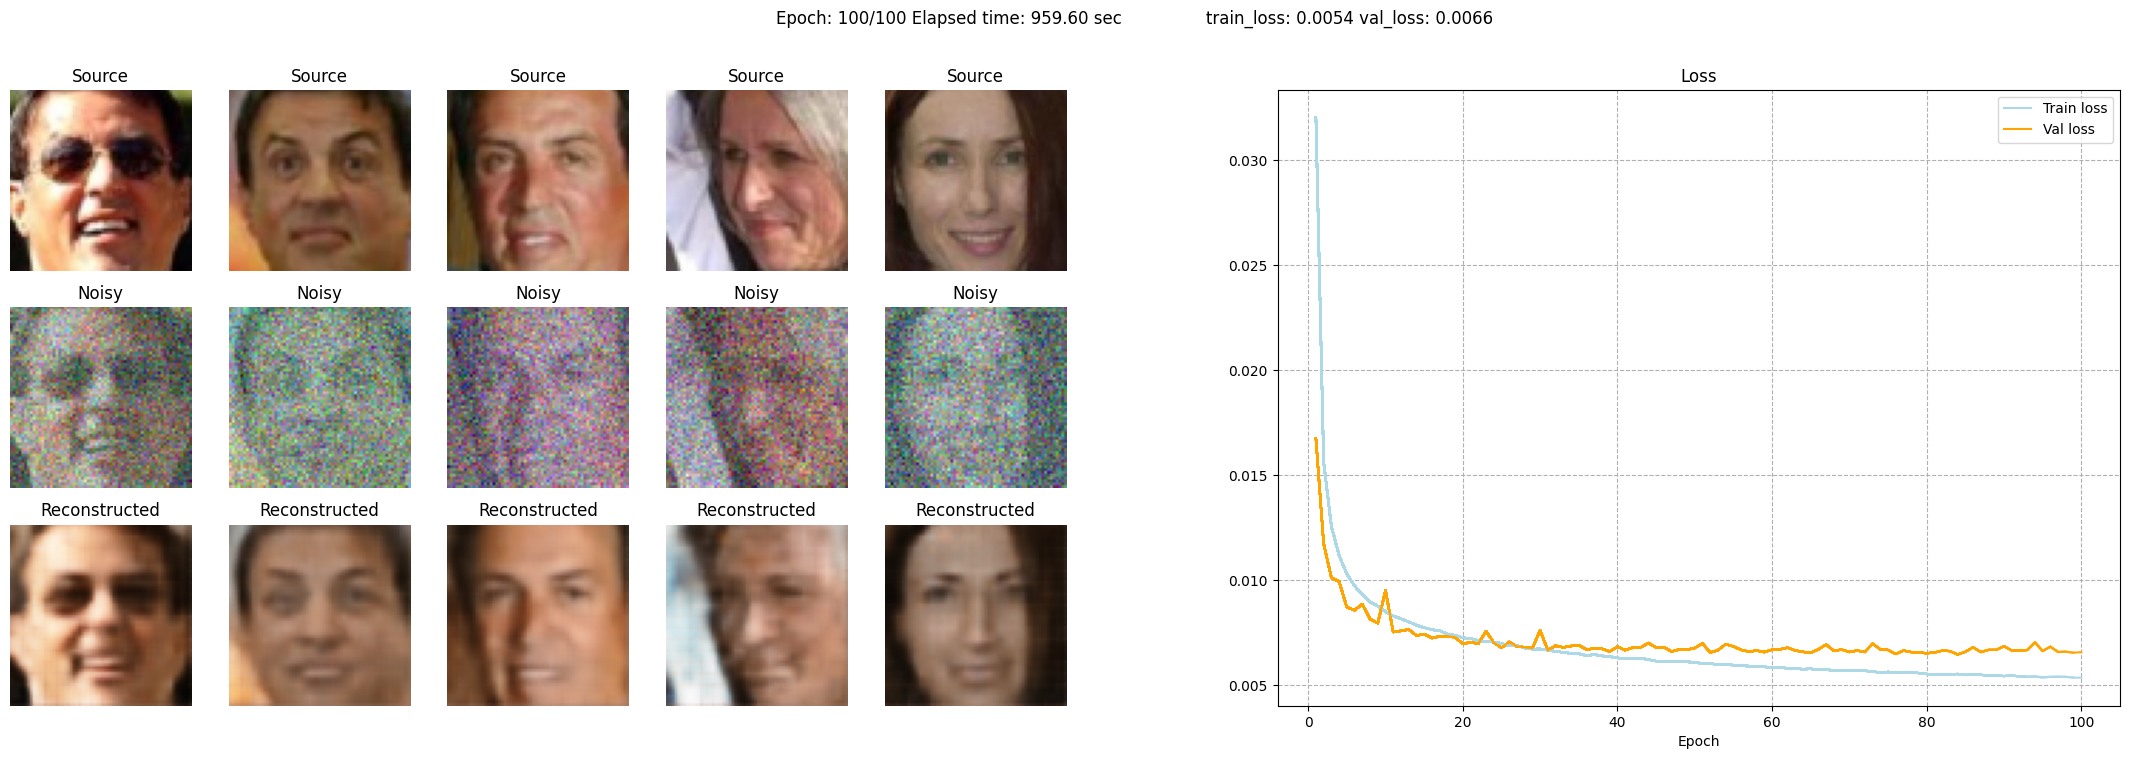

In [ ]:
denoiser_history = denoiser_train(denoiser,denoise_optimizer, denoise_criterion, 100, train_loader, val_loader, viz=True, scheduler=None, alpha=0.2)

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
# Создадим новый даталоадер, без Shuffle, чтобы было удобно с индексами работать.
non_shuffle_loader = torch.utils.data.DataLoader(train_photos, batch_size=50, shuffle=False)

In [ ]:
# Вариационный автоэнкодер
class RetrievalVAE(nn.Module):
    def __init__(self, latent_dim):
        super(RetrievalVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(128*8*8, self.latent_dim*2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128*8*8),
            nn.Unflatten(dim=1, unflattened_size=(128, 8, 8)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1,2,self.latent_dim)
        mu = encoded[:,0,:]
        logsigma = encoded[:,1,:]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [ ]:
# Немного подправил функцию, чтобы можно было нормально жрать батчи из лоадеров мниста, и визуализировать адекватно.
def retrieval_train(model, opt, loss_fn, epochs, data_tr, data_val, viz=True, scheduler=None) -> pd.DataFrame:
    """ Функция обучения и валидации.

    Args:
        model - модель
        opt - оптимизатор
        loss_fn - функция потерь
        epochs - количество эпох
        data_tr - трэйн-сет
        data_val - валидационный сет
        viz - визуализация промежуточных результатов
        scheduler - scheduler, если используется. По-умолчанию None.

    Returns:
        history: {
               epoch: номер эпохи
               train_loss: значение функции потерь на трэйн-сете
               val_loss: значения функции потерь на валидационном сете
               train_score: значение метрики на трэйн-сете
               val_score: значение метрики на валидационном сете
              }
    """
    model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}

    best_weights = model.state_dict()
    best_loss = 1e-8


    if viz:
        # Берём батч для визуализации. На каждой эпохе будем визуализировать результат именно на нём.
        X_viz = next(iter(data_val))

        # Создаем фигуру и axes для визуализации.
        fig = plt.figure(figsize=(25,5), facecolor='w')
        gs0 = fig.add_gridspec(1, 2)
        gs00 = gs0[0].subgridspec(2, 5)
        gs01 = gs0[1].subgridspec(2, 5)
        for a in range(2):
            for b in range(5):
                fig.add_subplot(gs00[a, b])
        fig.add_subplot(gs01[:,:-2] );

        # tqdm нам в этом случае не нужен, поэтому просто range создаем.
        pbar = range(epochs)
    else:
        # Если визуализации нет, будем выводить лосс и скор через tqdm
        pbar = trange(epochs, desc='Epoch:')
    tic = time.time()
    for epoch in pbar:

        # Обнуляем лоссы и метрики.
        avg_train_loss = 0
        avg_val_loss = 0

        # Train loop
        model.train()  # переводим модель в train mode
        for X_batch in data_tr:
            # Скидываем батч на девайс
            X_batch = X_batch.to(device)
            # обнуляем градиенты
            opt.zero_grad()
            # forward
            mu, logsigma, reconstruction = model(X_batch)
            loss =  loss_fn(X_batch, mu, logsigma, reconstruction)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # обновляем веса


            # Считаем лосс
            avg_train_loss += loss / len(data_tr)

        # Val loop
        model.eval()  # переводим модель в eval mode
        with torch.no_grad():
            for X_val_batch in data_val:
                # Скидываем батч на девайс
                X_val_batch = X_val_batch.to(device)
                # forward
                val_mu, val_logsigma, val_reconstruction = model(X_val_batch)
                val_loss =  loss_fn(X_val_batch, val_mu, val_logsigma, val_reconstruction) # forward-pass
                # Считаем лосс
                avg_val_loss += val_loss / len(data_val)
        # Сохраняем лучший лосс и веса
        if avg_val_loss.cpu().item() < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())
        if scheduler:
            scheduler.step()

        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss.cpu().item())
        history['val_loss'].append(avg_val_loss.cpu().item())

        # Убираем всё что можно с gpu, чистим кэш.
        reconstruction.cpu()
        val_reconstruction.cpu()
        avg_val_loss.cpu()
        avg_train_loss.cpu()
        X_batch.cpu(),
        X_val_batch.cpu()
        loss.cpu()
        val_loss.cpu()
        torch.cuda.empty_cache()

        # Визуализируем промежуточные результаты
        model.eval()  # Переводим модель в eval mode
        if not viz:
            pbar.set_description(f'train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
        else:
            Y_hat = model(X_viz.to(device))[2].detach().cpu()# сбрасываем предикт на cpu
            display.clear_output(wait=True)
            tempdf = pd.DataFrame(history)
            for k in range(5):
                fig.axes[k].imshow(X_viz[k].permute((1,2,0)), cmap='gray')
                fig.axes[k].set_title('Source')
                fig.axes[k].set_axis_off()
                fig.axes[k+5].imshow(Y_hat[k].permute((1,2,0)), cmap='gray')
                fig.axes[k+5].set_title('Reconstructed')
                fig.axes[k+5].set_axis_off()
            fig.axes[-1].plot(history['epoch'], tempdf['train_loss'], label='Train loss', color='lightblue')
            fig.axes[-1].plot(history['epoch'], tempdf['val_loss'], label='Val loss', color='orange')
            fig.axes[-1].grid(True, linestyle='--')
            fig.axes[-1].set_xlabel('Epoch')
            fig.axes[-1].set_title('Loss')
            fig.axes[-1].legend(['Train loss','Val loss'])
            fig.suptitle(f'Epoch: {(epoch+1):d}/{epochs:d} Elapsed time: {(time.time()-tic):.2f} sec\
                train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
            display.display(plt.gcf())
    if viz:
        # перетираем display, чтобы изображение обновлялось
        display.clear_output(wait=True)

    # Сбрасываем модель на cpu. Чистим кэш.
    model.cpu()
    model.load_state_dict(best_weights)
    torch.cuda.empty_cache()
    return pd.DataFrame(history)

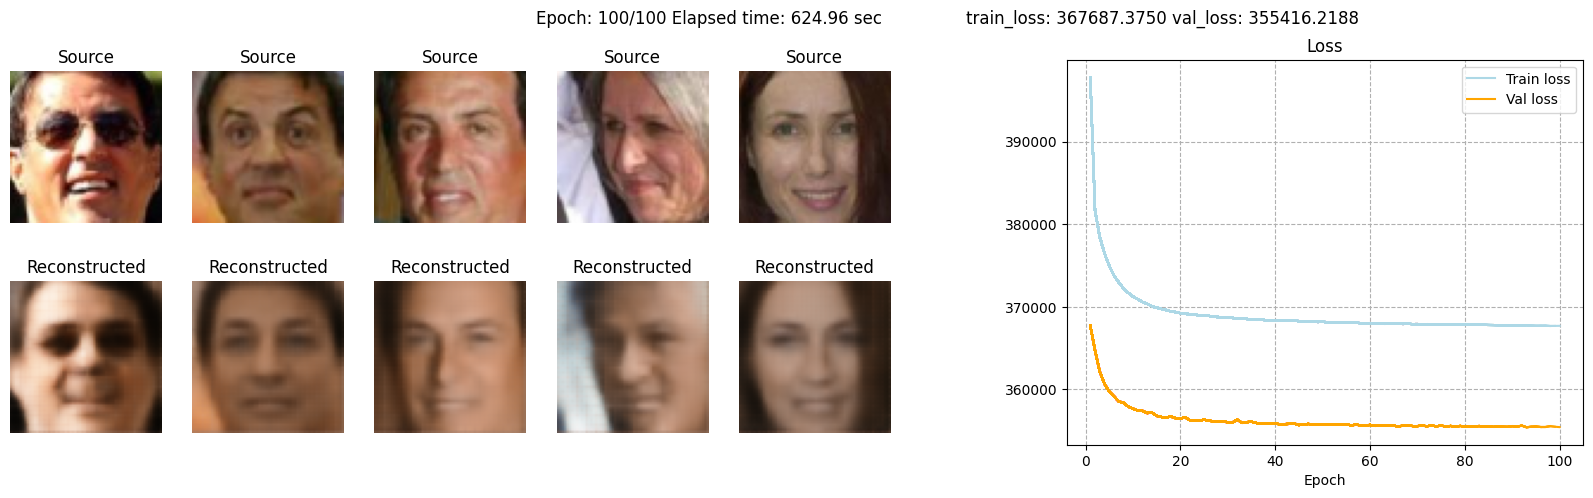

In [ ]:
# Создаём модель, лосс, оптимизатор
retrieval = RetrievalVAE(512)
retrieval_loss = loss_vae
retrieval_optimizer = torch.optim.AdamW(retrieval.parameters(), lr=3e-4, amsgrad=True)

# Обучаем 100 эпох. Реконструирует слабенько, но видимо признаки вполне нормально выучивает, это будет по визуализации ближайших фото.
retrieval_history = retrieval_train(retrieval, retrieval_optimizer, retrieval_loss, 100, train_loader, val_loader, viz=True, scheduler=None)

In [ ]:
# Получаем векторы для всех фото train сета.
codes = torch.FloatTensor()
with torch.no_grad():
    retrieval.eval()
    for batch in non_shuffle_loader:
        code,_ = retrieval.encode(batch)
        codes = torch.cat((codes,code))

In [ ]:
# Функция для визуализации исходного фото и нескольких ближайших к нему.
# Получаем вектор для фото, считаем метрику cosine similarity
def visualize_similarity(num_photo):
    with torch.no_grad():
        test_code = retrieval.encode(val_photos[num_photo][None,...])[0]
    sim = torch.nn.CosineSimilarity()
    sims = sim(codes,test_code)
    sorted_sims = sims.argsort(descending=True)[:5]
    plt.figure(figsize=(12,5))
    plt.subplot(1,6,1)
    plt.imshow(val_photos[num_photo].permute((1,2,0)))
    plt.axis('off')
    plt.title('Source')
    for i in range(5):
        plt.subplot(1,6,i+2)
        plt.imshow(train_photos[sorted_sims[i]].permute((1,2,0)))
        plt.axis('off')
        plt.title(f'sim={sims[sorted_sims[i]]:.4f}')

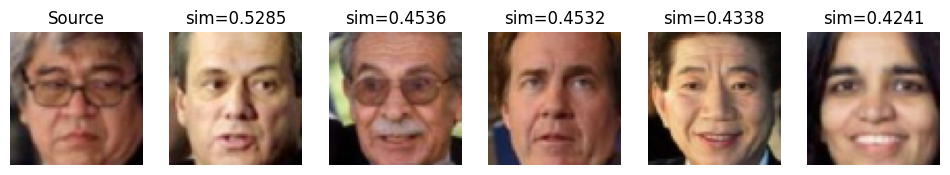

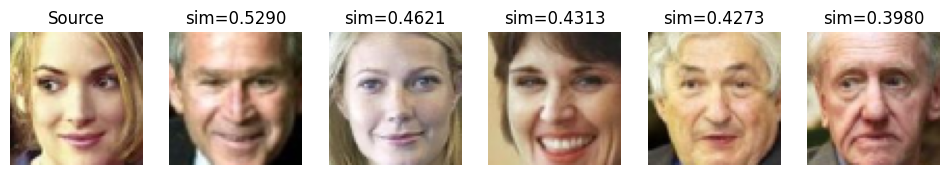

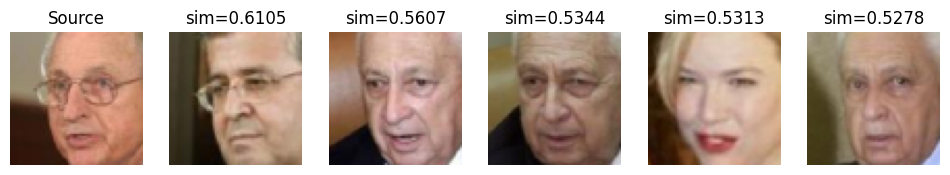

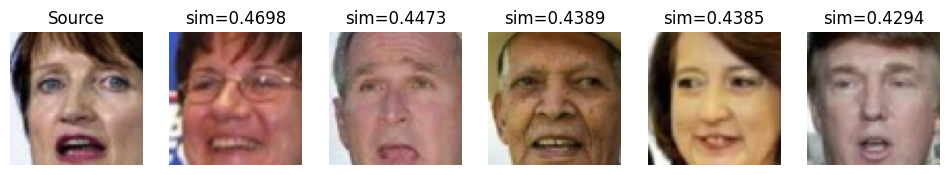

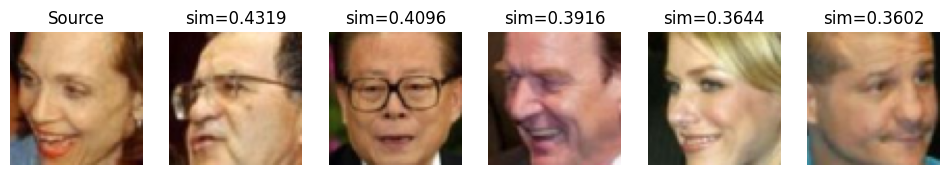

In [ ]:
# Визуализируем несколько случайных фото из валидационного сета и по 5 ближайших к ним из тренировочного
samples = np.random.randint(0, len(val_photos),5)
for sample in samples:
    visualize_similarity(sample)